In [85]:
from bitstring import BitArray, BitStream
from h264bits import H264Bits

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [87]:
from nalsps import SPS
from nalpps import PPS
from nalslice import Slice

In [88]:
input_file = open("data/baseline.264", "rb")
nalus_ba = list(BitArray(input_file).split('0x000001', bytealigned=True))[1:]
input_file.close()

In [89]:
ppss = []
slices = []

In [90]:
for nalu_ba in nalus_ba:
    print(nalu_ba)
    # enulation_prevention_three_byte
    nalu_ba.replace('0x000003', '0x0000', bytealigned=True)
    nalu_bs = BitStream(nalu_ba)
    nb = H264Bits(nalu_bs)
    params = {"forbidden_zero_bit" : nb.f(1),
              "nal_ref_idc" : nb.u(2),
              "nal_unit_type" : nb.u(5)}
    print(params)
    # if params["nal_unit_type"] == 7: # SPS
    #     sps = SPS(nb, params = params)
    #     # dump_params(sps, "sps.json")
    # elif params["nal_unit_type"] == 8: # PPS
    #     pps = PPS(nb, sps = sps, params = params)
    #     ppss.append(pps)
    #     fname = "pps_" + str(len(ppss)) + ".json"
    #     # dump_params(pps, fname)
    # elif params["nal_unit_type"] in [1, 5]: # Slice
    #     slice = Slice(nb, sps = sps, ppss = ppss, params = params)
    #     # decode_slice(slice)
    #     break
    #     slices.append(slice)
    #     dump_mbs(slice, "slice_" + str(len(slices)) + "_mb.json")
    #     fname = "slice_" + str(len(slices)) + ".json"
    #     dump_params(slice, fname)
    # else:
    #     print("Unknown Slice type, ignore...")


0x0000016742c00bd902c4e840000003004000000c83c50a9200
{'forbidden_zero_bit': 0, 'nal_ref_idc': 3, 'nal_unit_type': 7}
0x00000168cb83cb20
{'forbidden_zero_bit': 0, 'nal_ref_idc': 3, 'nal_unit_type': 8}
0x0000010605ffff6ddc45e9bde6d948b7962cd820d923eeef78323634202d20636f7265203134382072323639392061356530366239202d20482e3236342f4d5045472d342041564320636f646563202d20436f70796c65667420323030332d32303136202d20687474703a2f2f7777772e766964656f6c616e2e6f7267...
{'forbidden_zero_bit': 0, 'nal_ref_idc': 0, 'nal_unit_type': 6}
0x000001658884087c41c45e040fbbf0031c63dd53d4a1fde892ea3b0b62fe7c9c327ce9b6e15234897500b8c2fe108e931af979c08ccf08fa4d4e9abf54697960724181546d27cb9c0829d46272ff8fdddde729670b6d3dc0b53d0b2c852f6f7c155d81823de200e4cdc6462a47c6406b49dce483962b8d1fa6edf0330c...
{'forbidden_zero_bit': 0, 'nal_ref_idc': 3, 'nal_unit_type': 5}
0x000001419a3812e69fae0b87f260be6c6a19d57f96ba5e5fc8bfdf74d72a2df26259d55f97ac4dd562e5957d7aa0bc718b3625d608440b21a979ecf7d606038bb4d7a97d1e0b4a6c432eb088993f24

**RBSP (Raw Byte Sequence Payload)**: Contains syntax structures such as SPS, PPS, slice data, etc., with Emulation Prevention Bytes (EPBs) removed.

In [91]:
# SPS
sps = {}
nalu_ba = nalus_ba[0]
print(nalu_ba)
nalu_ba.replace('0x000003', '0x0000', bytealigned=True)
nalu_bs = BitStream(nalu_ba)
nb = H264Bits(nalu_bs)
params = {"forbidden_zero_bit" : nb.f(1),
            "nal_ref_idc" : nb.u(2),
            "nal_unit_type" : nb.u(5)}
print(params)

sps = SPS(nb, params = params)

print(sps)

0x0000016742c00bd902c4e8400000004000000c83c50a9200
{'forbidden_zero_bit': 0, 'nal_ref_idc': 3, 'nal_unit_type': 7}


In [92]:
# PPS 
nalu_ba = nalus_ba[1]
print(nalu_ba)
nalu_ba.replace('0x000003', '0x0000', bytealigned=True)
nalu_bs = BitStream(nalu_ba)
nb = H264Bits(nalu_bs)
params = {"forbidden_zero_bit" : nb.f(1),
            "nal_ref_idc" : nb.u(2),
            "nal_unit_type" : nb.u(5)}
print(params)

pps = PPS(nb, sps = sps, params = params)
ppss.append(pps)

print(pps)

0x00000168cb83cb20
{'forbidden_zero_bit': 0, 'nal_ref_idc': 3, 'nal_unit_type': 8}


In [93]:
# SEI
nalu_ba = nalus_ba[2]
print(nalu_ba)
nalu_ba.replace('0x000003', '0x0000', bytealigned=True)
nalu_bs = BitStream(nalu_ba)
nb = H264Bits(nalu_bs)
params = {"forbidden_zero_bit" : nb.f(1),
            "nal_ref_idc" : nb.u(2),
            "nal_unit_type" : nb.u(5)}
print(params)

0x0000010605ffff6ddc45e9bde6d948b7962cd820d923eeef78323634202d20636f7265203134382072323639392061356530366239202d20482e3236342f4d5045472d342041564320636f646563202d20436f70796c65667420323030332d32303136202d20687474703a2f2f7777772e766964656f6c616e2e6f7267...
{'forbidden_zero_bit': 0, 'nal_ref_idc': 0, 'nal_unit_type': 6}


In [94]:
def decode_slice(slice):
    for mb in slice.mbs:
        import intra_pred
        intra_pred.luma_pred(mb)
        intra_pred.chroma_pred(mb)
    # utilities.pic_paint(slice.S_prime_L, "Luma")
    # utilities.pic_paint(slice.S_prime_Cb, "Cb")
    # utilities.pic_paint(slice.S_prime_Cr, "Cr")


In [95]:
# IDR
nalu_ba = nalus_ba[3]
print(nalu_ba)
nalu_ba.replace('0x000003', '0x0000', bytealigned=True)
nalu_bs = BitStream(nalu_ba)
nb = H264Bits(nalu_bs)
params = {"forbidden_zero_bit" : nb.f(1),
            "nal_ref_idc" : nb.u(2),
            "nal_unit_type" : nb.u(5)}
print(params)

slice = Slice(nb, sps = sps, ppss = ppss, params = params)
decode_slice(slice)

print(slice)

0x000001658884087c41c45e040fbbf0031c63dd53d4a1fde892ea3b0b62fe7c9c327ce9b6e15234897500b8c2fe108e931af979c08ccf08fa4d4e9abf54697960724181546d27cb9c0829d46272ff8fdddde729670b6d3dc0b53d0b2c852f6f7c155d81823de200e4cdc6462a47c6406b49dce483962b8d1fa6edf0330c...
{'forbidden_zero_bit': 0, 'nal_ref_idc': 3, 'nal_unit_type': 5}


In [96]:
def show_frame(frame, title):
    plt.imshow(frame, cmap='gray')
    plt.title(title)
    plt.show()

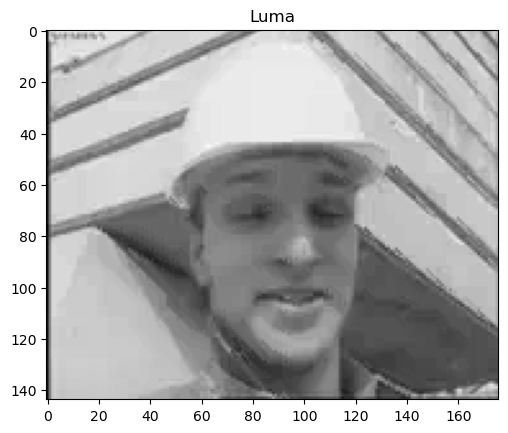

In [97]:
L = np.array(slice.S_prime_L).T
L.shape
show_frame(L, "Luma")

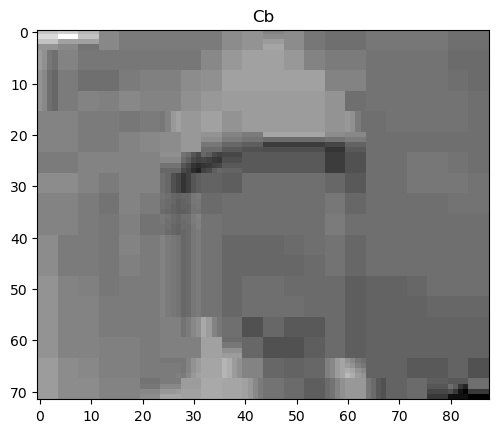

In [98]:
Cb = np.array(slice.S_prime_Cb).T
Cb.shape
show_frame(Cb, "Cb")

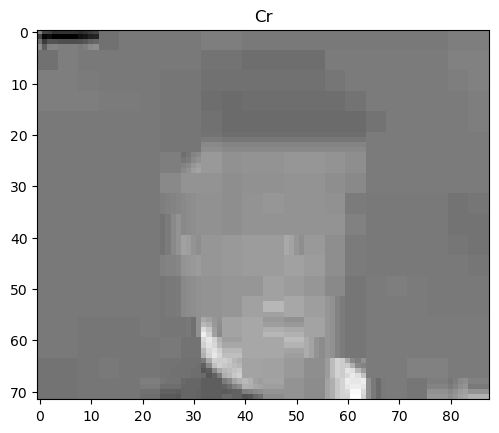

In [99]:
Cr = np.array(slice.S_prime_Cr).T
Cr.shape
show_frame(Cr, "Cr")

In [100]:
def yuv2rgb(yuv, width, height):
    # Convert YUV to RGB
    m = np.array([[1.0, 1.0, 1.0], [-0.000007154783816076815, -0.3441331386566162, 1.7720025777816772], [1.4019975662231445, -0.7141380310058594 , 0.00001542569043522235]])
    rgb = np.dot(yuv - 128, m)
    rgb[:,:,0] += 179.45477266423404
    rgb[:,:,1] += 135.45870971679688
    rgb[:,:,2] += 226.8183044444304
    rgb = np.clip(rgb, 0, 255)
    return rgb.astype(np.uint8)

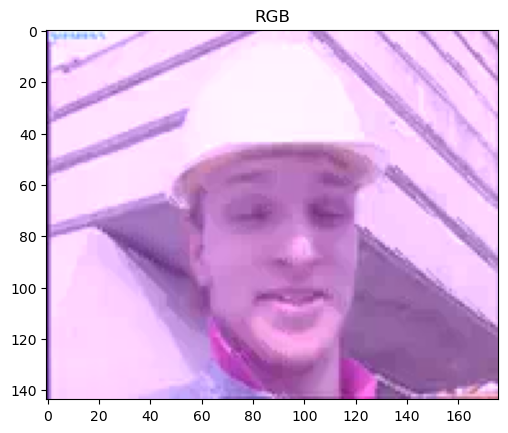

In [101]:
# Assuming slice.S_prime_L, slice.S_prime_Cb, and slice.S_prime_Cr are your Y, U, and V components
Y = np.array(slice.S_prime_L).T
U = np.array(slice.S_prime_Cb).T
V = np.array(slice.S_prime_Cr).T

# Upsample U and V components to match Y
u_upsampled = zoom(U, 2)
v_upsampled = zoom(V, 2)

# Stack Y, U, and V components to create a YUV image
yuv = np.dstack((Y, u_upsampled, v_upsampled))

rgb = yuv2rgb(yuv, 176, 144)
show_frame(rgb, "RGB")